In [27]:
%matplotlib inline

In [1]:
import pandas as pd
import numpy as np
import sbibm
import torch
import math
import torch.distributions as D
import matplotlib.pyplot as plt
import torch.nn.functional as F

from pyknos.nflows import flows, transforms
from functools import partial
from typing import Optional
from warnings import warn

from pyknos.nflows import distributions as distributions_
from pyknos.nflows import flows, transforms
from pyknos.nflows.nn import nets
from pyknos.nflows.transforms.splines import rational_quadratic
from torch import Tensor, nn, relu, tanh, tensor, uint8

import seaborn as sns
import matplotlib as mpl
import matplotlib.pyplot as plt

mpl.rcParams['text.usetex'] = True
mpl.rcParams['mathtext.fontset'] = 'stix'
mpl.rcParams['font.family'] = 'STIXGeneral'
mpl.rcParams['text.latex.preamble'] = r'\usepackage{amsfonts}'

sns.set_theme()

from sbi.utils.sbiutils import (
    standardizing_net,
    standardizing_transform,
    z_score_parser,
)
from sbi.utils.torchutils import create_alternating_binary_mask
from sbi.utils.user_input_checks import check_data_device, check_embedding_net_device

import os
import pickle
import argparse

from point_predictor import SimpleModel

In [54]:
device = "cpu"
task_name = "two_moons"
task = sbibm.get_task(task_name)
prior = task.get_prior_dist()
simulator = task.get_simulator()    

model = torch.load(f"{task_name}.pt")

epoch = 5_000
sampler_fn = os.path.join("results", f"{task_name}_epoch={epoch}.nf")
with open(sampler_fn, "rb") as f:
    sampler = pickle.load(f)
sampler.to(device)

# compute conformal quantile
conformal_samples = 1_000
cal_y = prior.sample((conformal_samples,))
cal_x = simulator(cal_y)
cal_y_pred, _ = model(cal_x)
cal_scores = ((cal_y - cal_y_pred) ** 2).mean(axis=1).detach().numpy()

alpha = 0.05
desired_coverage = 1 - alpha
quantile = np.quantile(cal_scores, q = desired_coverage)

In [59]:
# sample region for construction
region_samples = 500
y = prior.sample((1,))
x = simulator(y)
y_pred, _ = model(x)

In [60]:
zs = sampler.sample((region_samples), x)
sampled_ys = model.fc4(zs).squeeze()
sampled_scores = ((sampled_ys - y_pred) ** 2).mean(axis=1).detach().numpy()
sampled_region = sampled_ys[sampled_scores < quantile].detach().numpy()

<Axes: >

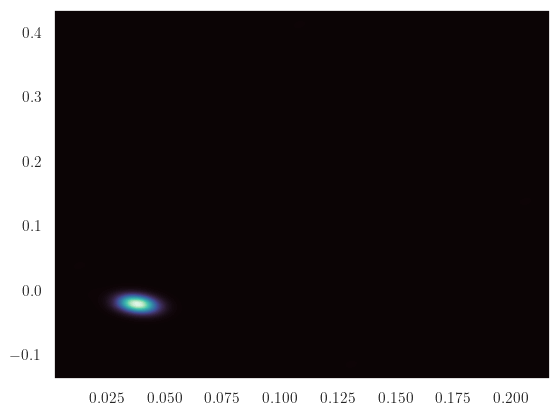

In [63]:
sns.kdeplot(
    x=sampled_region[:,0], y=sampled_region[:,1], 
    fill=True, thresh=0, levels=100, cmap="mako",
)